<code>plot_VRILE_counts_vs_month.ipynb</code>

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob2
from scipy import signal 
import seaborn as sns
import os

We want to create a few aggregate regions from the NSIDC MASIE regions (more at: https://nsidc.org/data/masie/browse_regions) since some regions are so small. We're going to combine the following: <br>
<li> Kara and Laptev Seas (<code>region_KL</code>)</li>
<li> Barents, Kara and Laptev Seas (<code>region_BKL</code>)</li>
<li> East Siberian, Beaufort, and Chukchi Seas (<code>region_EBC</code>)</li>
<li> Atlantic (Baffin Bay and East Greenland Sea) (<code>region_ATL</code>)</li>
<li> East Siberian, Beaufort, Chukchi, Laptev Seas (<code>region_EBCL</code>)</li>


In [2]:
def create_aggregate_regions(SIE_data):
    nregions = SIE_data['nregions']
    region_names = SIE_data['region_names']
    # Get corresponding indices for each of our aggregate regions
    region_KL = nregions[region_names.isin(['Kara Sea','Laptev Sea'])]
    region_BKL = nregions[region_names.isin(['Barents Sea','Kara Sea','Laptev Sea'])]
    region_EBC = nregions[region_names.isin(['East Siberian Sea','Beaufort Sea','Chukchi Sea'])]
    region_ATL = nregions[region_names.isin(['Baffin Bay','East Greenland Sea'])]
    region_EBCL = nregions[region_names.isin(['East Siberian Sea','Beaufort Sea','Chukchi Sea','Laptev Sea'])]
    # Select each aggregate region, add them together, and add the 'nregions' dimension back; concatenate all aggregates 
    SIE_agg = xr.concat([SIE_data.sel(nregions=region_KL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_BKL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_EBC).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_ATL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_EBCL).sum(dim='nregions').expand_dims(dim='nregions')],dim='nregions')
    # Add coordinates to nregions.  Start at 20 to make a clear separation from original NSIDC regions
    SIE_agg = SIE_agg.assign_coords(nregions=[20,21,22,23,24])
    # Add region names
    region_names_extra = ['Kara-Laptev Sea','Barents-Kara-Laptev Sea','East Siberian-Beaufort-Chukchi Sea',
                      'Atlantic','East Siberian-Beaufort-Chukchi-Laptev Sea']
    SIE_agg["region_names"] = ("nregions",region_names_extra)
    #SIE
    SIE_data = xr.concat([SIE_data,SIE_agg],dim='nregions')
    return(SIE_data)

Create climatology for the observations.  This is easier, we just need to get the day of year (month-day) for each observation, take the mean, and then subtract the annual cycle from our full dataset. 

In [3]:
def create_obs_climatology(SIE):
    # Add valid date in %m-%d format
    SIE['valid day of year'] = pd.to_datetime(SIE['valid date']).dt.strftime('%m-%d')
    # Group by region and day of year and take the mean. Use transform to make the output match the dataframe instead
    # of creating a multi-index
    SIE['SIE clim'] = SIE.groupby(['region','valid day of year'])['SIE'].transform('mean')
    # And simply subtract SIE_clim from actual SIE
    SIE['SIE anom'] = SIE['SIE'] - SIE['SIE clim']
    return SIE

Calculate VRILE days from obs.  Determine $n$-day changes in SIE and anomalous SIE, and estimate the lower tail of the distribution based on <code>VRILE_thresh</code>.  For now, we'll assume we need a 5-day change in SIE.  

In [4]:
def calc_VRILE_thresh(obs_SIE,vrile_thresh,nday_change,seas_sel,seas_str):
    # Use shift to move SIE/SIE anom foreward and backward by nday_change days
    nday_shift = np.floor(nday_change/2)
    obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
    obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
    obs_SIE['SIE -n'] = obs_SIE.groupby(['region'])['SIE'].shift(-nday_shift)
    obs_SIE['SIE +n'] = obs_SIE.groupby(['region'])['SIE'].shift(+nday_shift)
    obs_SIE['d_SIE'] = obs_SIE['SIE -n'] - obs_SIE['SIE +n']
    obs_SIE['d_SIE anom'] = obs_SIE['SIE anom -n'] - obs_SIE['SIE anom +n']
    # Trim to correct season based on seas_sel
    if seas_str == 'ALL':
        obs_SIE['SIE p05'] = obs_SIE.groupby(['region'])['d_SIE'].transform(lambda x: x.quantile(vrile_thresh))
        obs_SIE['SIE anom p05'] = obs_SIE.groupby(['region'])['d_SIE anom'].transform(lambda x: x.quantile(vrile_thresh))

    # Identify VRILE days based on vrile_thresh
    else:
        obs_SIE['SIE p05'] = obs_SIE.groupby(['region'])['d_SIE',
                                     'valid date'].transform(lambda x: x[pd.to_datetime(x['valid date']).dt.month.isin(seas_sel)].quantile(vrile_thresh))
        obs_SIE['SIE anom p05'] = obs_SIE.groupby(['region'])['d_SIE anom',
                                          'valid date'].transform(lambda x: x[pd.to_datetime(x['valid date']).dt.month.isin(seas_sel)].quantile(vrile_thresh))
    obs_SIE_VRILE_only = obs_SIE.groupby(['region']).apply(lambda x: x[x['d_SIE'] <= x['SIE p05']])
    obs_SIE_anom_VRILE_only = obs_SIE.groupby(['region']).apply(lambda x: x[x['d_SIE anom'] <= x['SIE anom p05']])
    # Keep only VRILE days
    obs_SIE_VRILE_only = obs_SIE_VRILE_only.reset_index(level=0, drop=True).reset_index()
    obs_SIE_anom_VRILE_only = obs_SIE_anom_VRILE_only.reset_index(level=0, drop=True).reset_index()
    return obs_SIE_VRILE_only, obs_SIE_anom_VRILE_only

In [5]:
seas_str = 'ALL'
seas_sel = []
obs_name = 'NSIDC_0079'
WEEKLY = False
vrile_thresh = 0.05
thresh_str = '05'
nday_change = 5
plot_quant = 'd_SIE anom'
save_str = 'SIE_anom'
COMMON_REFORECAST = True

Load observations

In [6]:
obs_type = 'sipn_nc_yearly_agg'
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')

opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11322)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-12-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


Add aggregate regions to obs and convert obs to Pandas dataframe

In [7]:
obs_SIE = create_aggregate_regions(obs_SIE)
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})
if COMMON_REFORECAST == True:
    obs_SIE = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.year.isin(np.arange(1999,2015))]

Calculate our observed climatology 

In [8]:
obs_SIE = create_obs_climatology(obs_SIE)
print('observed climatology created')

observed climatology created


Get observed VRILE days by shifting forwards/backwards by $n$

In [9]:
# Use shift to move SIE/SIE anom foreward and backward by nday_change days
nday_shift = np.floor(nday_change/2)
obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
obs_SIE['SIE -n'] = obs_SIE.groupby(['region'])['SIE'].shift(-nday_shift)
obs_SIE['SIE +n'] = obs_SIE.groupby(['region'])['SIE'].shift(+nday_shift)
obs_SIE['d_SIE'] = obs_SIE['SIE -n'] - obs_SIE['SIE +n']
obs_SIE['d_SIE anom'] = obs_SIE['SIE anom -n'] - obs_SIE['SIE anom +n']


In [10]:
obs_SIE

,valid date,nregions,region,SIE,valid day of year,SIE clim,SIE anom,SIE anom -n,SIE anom +n,SIE -n,SIE +n,d_SIE,d_SIE anom
73040,1999-01-01,99,panArctic,14.042518,01-01,13.468947,5.735711e-01,0.512381,NaN,14.080209,NaN,NaN,NaN
73041,1999-01-01,2,Sea of Okhotsk,0.755715,01-01,0.548772,2.069425e-01,0.175757,NaN,0.760640,NaN,NaN,NaN
73042,1999-01-01,3,Bering,0.567497,01-01,0.560519,6.978299e-03,-0.006019,NaN,0.572859,NaN,NaN,NaN
73043,1999-01-01,4,Hudson Bay,1.233464,01-01,1.219998,1.346571e-02,0.011957,NaN,1.233464,NaN,NaN,NaN
73044,1999-01-01,5,St John,0.030842,01-01,0.043329,-1.248666e-02,-0.000537,NaN,0.055880,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189915,2014-12-31,20,Kara-Laptev Sea,1.791022,12-31,1.779339,1.168325e-02,NaN,2.096291e-02,NaN,1.791022,NaN,NaN
189916,2014-12-31,21,Barents-Kara-Laptev Sea,2.417750,12-31,2.382983,3.476707e-02,NaN,6.920010e-02,NaN,2.438862,NaN,NaN
189917,2014-12-31,22,East Siberian-Beaufort-Chukchi Sea,3.074202,12-31,3.074202,8.881784e-16,NaN,8.881784e-16,NaN,3.074202,NaN,NaN
189918,2014-12-31,23,Atlantic,1.707697,12-31,1.643130,6.456748e-02,NaN,-1.539574e-02,NaN,1.598276,NaN,NaN


Add month of region, and set index of dataframe to <code>region</code>

In [11]:
obs_SIE['valid date month'] = pd.to_datetime(obs_SIE['valid date']).dt.month
region_names = obs_SIE['region'].unique().tolist()
obs_SIE = obs_SIE.set_index('region')

Calculate the <code>vrile_thresh</code>th percentile of the $n$-day change in SIE (or SIE anom) using the months in <code>seas_sel</code>.  Then, keep only the days where the $n$-day change is less than or equal to our threshold

In [12]:
obs_SIE_VRILE_only = pd.DataFrame()
for ireg in region_names:
    SIE_ireg = obs_SIE.loc[ireg]
    if seas_str == 'ALL':
        SIE_ireg['p05'] = SIE_ireg[plot_quant].quantile(vrile_thresh)
    else:
        SIE_ireg['p05'] = SIE_ireg[SIE_ireg['valid date month'].isin(seas_sel)][plot_quant].quantile(vrile_thresh)
    SIE_ivrile = SIE_ireg.where(SIE_ireg[plot_quant]<=SIE_ireg['p05']).dropna(how='all')
    obs_SIE_VRILE_only = obs_SIE_VRILE_only.append(SIE_ivrile)


/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
#SIE_ireg

Drop regions we aren't using at all:  Bering, Okhotsk, Hudson Bay, St John

In [14]:
regions_drop = ['Bering','Sea of Okhotsk','Hudson Bay','St John']
obs_SIE_VRILE_only = obs_SIE_VRILE_only.reset_index()
obs_SIE_VRILE_trim = obs_SIE_VRILE_only[~obs_SIE_VRILE_only['region'].isin(regions_drop)].dropna(how='all')

Plot all regions' VRILE count as a function of month and region

Save info

In [15]:
ftype = 'png'
fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/figures/obs_VRILE_count/'
if COMMON_REFORECAST:
    fpath_save = fpath_save+'COMMON_REFORECAST_ONLY/'
#if obs_name == 'NSIDC_0079':
#    fpath_save = fpath_save+'NSDIC_0079/'
if not os.path.exists(fpath_save):
    os.makedirs(fpath_save)

fname_save1 = fpath_save+'{save_str}_forecast_RMSE_{seas_str}_vs_VRILE_{reg_save_str}_VRILEthresh{thresh}.{ftype}'.format(save_str=save_str,
                                                                                                                  reg_save_str='ALL_REG',
                                                                                                                  seas_str=seas_str,
                                                                                                                thresh=thresh_str,
                                                                                                               ftype=ftype)


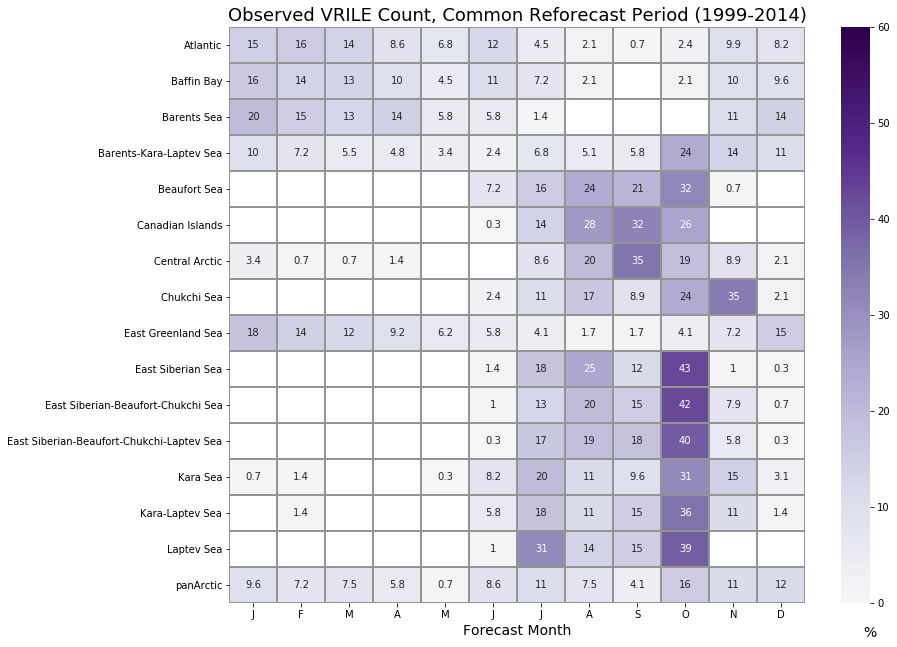

In [16]:
fig1 = plt.figure(1,figsize=(10,8))
ax1 = fig1.add_axes([0,0,1,1])
obs_SIE_VRILE_count = pd.pivot_table(data=obs_SIE_VRILE_trim,index='region',columns='valid date month',
                                     values='SIE',aggfunc=len)
obs_SIE_VRILEs_total = obs_SIE_VRILE_trim.groupby(['region']).count()
obs_pct = 100*(obs_SIE_VRILE_count*(1/obs_SIE_VRILEs_total['SIE'].mean())).round(3)
sns.heatmap(obs_pct,ax=ax1,center=0,vmin=0,vmax=60,annot=True,
           linewidth=1.3,linecolor='xkcd:gray',cmap='PuOr')
ax1.set_ylabel('',fontsize=14)
ax1.set_xlabel('Forecast Month',fontsize=14)
ax1.set_xticks(np.arange(0.5,12.5))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
if COMMON_REFORECAST == True:
    ax1.set_title('Observed VRILE Count, Common Reforecast Period (1999-2014)',fontsize=18)
else:
    ax1.set_title('Observed VRILE Count',fontsize=18)
ax1.collections[0].colorbar.set_label('%',rotation=0,fontsize=14,y=-0.04,labelpad=-20)
fig1.savefig(fname_save1,format=ftype,dpi=400,bbox_inches='tight')

Same, but only for our final regions

In [17]:
#fname_save2 = fpath_save+'{save_str}_forecast_RMSE_{seas_str}_vs_VRILE_{reg_save_str}_VRILEthresh{thresh}.{ftype}'.format(save_str=save_str,
 #                                                                                                                 reg_save_str='REG_TRIM',
  #                                                                                                                seas_str=seas_str,
   #                                                                                                             thresh=thresh_str,
    #                                                                                                           ftype=ftype)


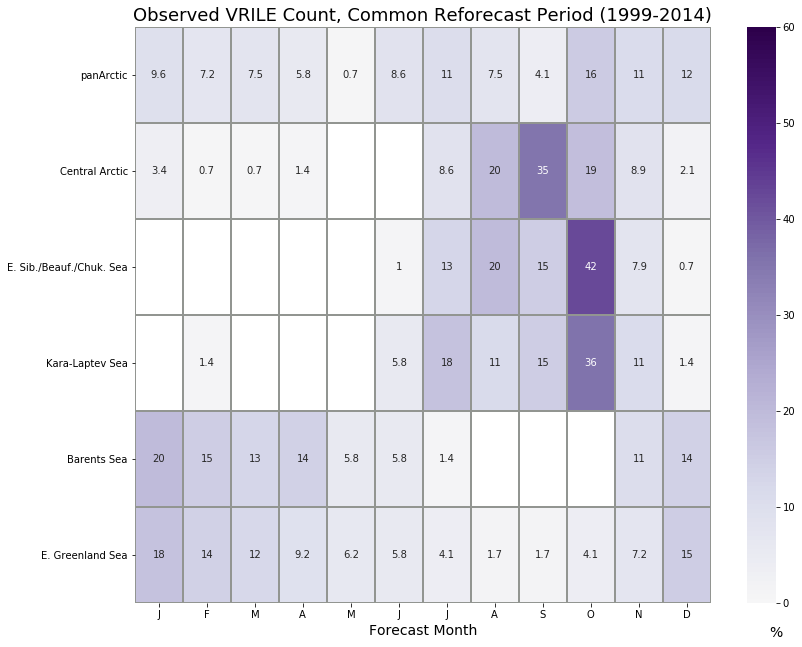

In [19]:
regions_sel = ['Barents Sea','East Greenland Sea','Central Arctic','panArctic',
               'East Siberian-Beaufort-Chukchi Sea','Kara-Laptev Sea']
obs_SIE_VRILE_sel = obs_SIE_VRILE_trim[obs_SIE_VRILE_trim['region'].isin(regions_sel)].dropna(how='all')
#
obs_SIE_VRILE_sel['region'] = obs_SIE_VRILE_sel['region'].replace({'East Greenland Sea':'E. Greenland Sea',
    'East Siberian-Beaufort-Chukchi Sea':'E. Sib./Beauf./Chuk. Sea'})
#
regions_sort = ["panArctic","Central Arctic","E. Sib./Beauf./Chuk. Sea","Kara-Laptev Sea","Barents Sea","E. Greenland Sea"]
obs_SIE_VRILE_sel['region sort'] = pd.Categorical(obs_SIE_VRILE_sel['region'],regions_sort)
#
obs_SIE_VRILE_count_sel = pd.pivot_table(data=obs_SIE_VRILE_sel,index='region sort',columns='valid date month',
                                     values='SIE',aggfunc=len)
obs_SIE_VRILEs_total_sel = obs_SIE_VRILE_sel.groupby(['region sort']).count()
obs_pct_sel = 100*(obs_SIE_VRILE_count_sel*(1/obs_SIE_VRILEs_total_sel['SIE'].mean())).round(3)
fig2 = plt.figure(2,figsize=(10,8))
ax2 = fig2.add_axes([0,0,1,1])

sns.heatmap(obs_pct_sel,ax=ax2,center=0,vmin=0,vmax=60,annot=True,
           linewidth=1.3,linecolor='xkcd:gray',cmap='PuOr')
ax2.set_ylabel('',fontsize=14)
ax2.set_xlabel('Forecast Month',fontsize=14)
ax2.set_xticks(np.arange(0.5,12.5))
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
if COMMON_REFORECAST == True:
    ax2.set_title('Observed VRILE Count, Common Reforecast Period (1999-2014)',fontsize=18)
else:
    ax2.set_title('Observed VRILE Count',fontsize=18)
ax2.collections[0].colorbar.set_label('%',rotation=0,fontsize=14,y=-0.04,labelpad=-20)
#fig2.savefig(fname_save2,format=ftype,dpi=400,bbox_inches='tight')

In [20]:
fpath_save_final = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/figures/Paper_Figures/'
fname_save_final = fpath_save_final+'obs_VRILE_count_{save_str}.pdf'.format(save_str=save_str)
fig2.savefig(fname_save_final,format='pdf',dpi=500,bbox_inches='tight')

In [21]:
fname_save_final

'/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/figures/Paper_Figures/obs_VRILE_count_SIE_anom.pdf'